
Time 0 | Observation: (0, 0)

Time 1 | Observation: (0, 0)

Time 2 | Observation: (0, 0)

Time 3 | Observation: (0, 0)

Time 4 | Observation: (0, 0)

Time 5 | Observation: (0, 0)

Time 6 | Observation: (0, 0)

Time 7 | Observation: (0, 0)

Time 8 | Observation: (0, 0)

Time 9 | Observation: (0, 0)


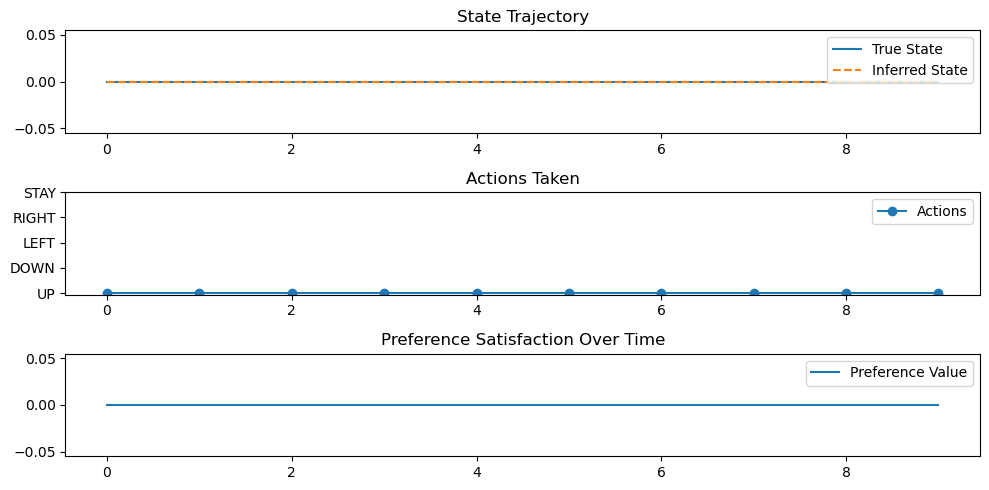

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from pymdp.agent import Agent
from pymdp import utils
from pymdp.maths import softmax

# === Set up the environment ===
grid_locations = [(0, 0), (0, 1), (0, 2),
                  (1, 0), (1, 1), (1, 2),
                  (2, 0), (2, 1), (2, 2)]

n_states = len(grid_locations)
n_observations = len(grid_locations)
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]
n_actions = len(actions)

# === A matrix: observation model ===
A = [np.eye(n_observations)]  # wrap in list for 1 observation modality

# === B matrix: transition model ===
def create_B_matrix():
    B = np.zeros((n_states, n_states, n_actions))
    for action_id, action_label in enumerate(actions):
        for curr_state, (y, x) in enumerate(grid_locations):
            if action_label == "UP":
                next_y = max(y - 1, 0)
                next_x = x
            elif action_label == "DOWN":
                next_y = min(y + 1, 2)
                next_x = x
            elif action_label == "LEFT":
                next_x = max(x - 1, 0)
                next_y = y
            elif action_label == "RIGHT":
                next_x = min(x + 1, 2)
                next_y = y
            elif action_label == "STAY":
                next_x, next_y = x, y
            new_location = (next_y, next_x)
            next_state = grid_locations.index(new_location)
            B[next_state, curr_state, action_id] = 1.0
    return B

# === A matrix (likelihood model)
A = utils.obj_array(1)  # 1 observation modality
A[0] = np.eye(n_observations)

# === B matrix (transition model)
B_matrix = create_B_matrix()
B = utils.obj_array(1)  # 1 hidden state factor
B[0] = B_matrix

# === C vector (preferences)
C = utils.obj_array(1)
C[0] = utils.onehot(grid_locations.index((2, 2)), n_observations)  # prefer (2,2)

# === D vector (prior belief)
D = utils.obj_array(1)
D[0] = utils.onehot(grid_locations.index((0, 0)), n_states)  # start in (0,0)

# === Create the agent ===
agent = Agent(A=A, B=B, C=C, D=D, num_controls=[n_actions])

# === Define environment ===
class GridWorldEnv:
    def __init__(self, starting_state=(0, 0)):
        self.init_state = starting_state
        self.current_state = starting_state

    def step(self, action_label):
        y, x = self.current_state
        if action_label == "UP":
            y = max(y - 1, 0)
        elif action_label == "DOWN":
            y = min(y + 1, 2)
        elif action_label == "LEFT":
            x = max(x - 1, 0)
        elif action_label == "RIGHT":
            x = min(x + 1, 2)
        self.current_state = (y, x)
        return self.current_state

    def reset(self):
        self.current_state = self.init_state
        return self.current_state

env = GridWorldEnv(starting_state=(0, 0))

# === Run active inference loop ===
T = 10
prior = D[0].copy()
obs = env.reset()

true_states = []
inferred_states = []
actions_taken = []

for t in range(T):
    print(f"\nTime {t} | Observation: {obs}")

    obs_idx = grid_locations.index(obs)
    qs = agent.infer_states([obs_idx])
    q_pi, efe = agent.infer_policies()
    raw_action = agent.sample_action()         # can be scalar, list, or array
    action = int(np.asarray(raw_action).flatten()[0])  # convert safely to Python int
    prior = B[0][:, :, action] @ softmax(qs[0])



    inferred_states.append(np.argmax(qs[0]))
    true_states.append(obs_idx)
    actions_taken.append(action)

    # update agent belief for next step
    prior = B[0][:, :, action] @ softmax(qs[0])
    agent.D = [prior]

    obs = env.step(actions[action])

# === Plot results ===
plt.figure(figsize=(10, 5))

plt.subplot(3, 1, 1)
plt.plot(true_states, label="True State")
plt.plot(inferred_states, '--', label="Inferred State")
plt.legend()
plt.title("State Trajectory")

plt.subplot(3, 1, 2)
plt.plot(actions_taken, 'o-', label="Actions")
plt.yticks(range(n_actions), actions)
plt.legend()
plt.title("Actions Taken")

plt.subplot(3, 1, 3)
plt.plot([C[0][s] for s in true_states], label="Preference Value")
plt.legend()
plt.title("Preference Satisfaction Over Time")

plt.tight_layout()
plt.show()


0: Observation state_observation: 2
0: Observation reward: 2
0: Observation decision_proprioceptive: 0
0: Beliefs about reward_level: [0.5 0.5]
0: Beliefs about decision_state: [1.e+00 3.e-16 3.e-16]
1
0: Action: [0. 2.] / State: [0, 2]
1: Observation state_observation: 0
1: Observation reward: 2
1: Observation decision_proprioceptive: 2
1: Beliefs about reward_level: [0.8 0.2]
1: Beliefs about decision_state: [1.64938489e-32 1.64938489e-32 1.00000000e+00]
1
1: Action: [0. 2.] / State: [0, 2]
2: Observation state_observation: 0
2: Observation reward: 2
2: Observation decision_proprioceptive: 2
2: Beliefs about reward_level: [0.94117647 0.05882353]
2: Beliefs about decision_state: [1.35620489e-32 1.35620489e-32 1.00000000e+00]
1
2: Action: [0. 1.] / State: [0, 1]
3: Observation state_observation: 2
3: Observation reward: 1
3: Observation decision_proprioceptive: 1
3: Beliefs about reward_level: [0.85477931 0.14522069]
3: Beliefs about decision_state: [9.64706076e-32 1.00000000e+00 9.647

In [39]:
import numpy as np
from pymdp.agent import Agent
from pymdp import utils
from pymdp.maths import softmax
import copy

obs_names = ["state_observation", "reward", "decision_proprioceptive"]
state_names = ["reward_level", "decision_state"]
action_names = ["uncontrolled", "decision_state"]

num_obs = [3, 3, 3]
num_states = [2, 3]
num_modalities = len(num_obs)
num_factors = len(num_states)

A = utils.obj_array_zeros([[o] + num_states for _, o in enumerate(num_obs)])

A[0][:, :, 0] = np.ones( (num_obs[0], num_states[0]) ) / num_obs[0]
A[0][:, :, 1] = np.ones( (num_obs[0], num_states[0]) ) / num_obs[0]
A[0][:, :, 2] = np.array([[0.8, 0.2], [0.0, 0.0], [0.2, 0.8]])

A[1][2, :, 0] = np.ones(num_states[0])
A[1][0:2, :, 1] = softmax(np.eye(num_obs[1] - 1)) # bandit statistics (mapping between reward-state (first hidden state factor) and rewards (Good vs Bad))
A[1][2, :, 2] = np.ones(num_states[0])

# establish a proprioceptive mapping that determines how the agent perceives its own `decision_state`
A[2][0,:,0] = 1.0
A[2][1,:,1] = 1.0
A[2][2,:,2] = 1.0

control_fac_idx = [1]
B = utils.obj_array(num_factors)
for f, ns in enumerate(num_states):
    B[f] = np.eye(ns)
    if f in control_fac_idx:
        B[f] = B[f].reshape(ns, ns, 1)
        B[f] = np.tile(B[f], (1, 1, ns))
        B[f] = B[f].transpose(1, 2, 0)
    else:
        B[f] = B[f].reshape(ns, ns, 1)

C = utils.obj_array_zeros(num_obs)
C[1][0] = 1.0  # put a 'reward' over first observation
C[1][1] = -2.0  # put a 'punishment' over first observation
# this implies that C[1][2] is 'neutral'

agent = Agent(A=A, B=B, C=C, control_fac_idx=[1])

# initial state
T = 5
o = [2, 2, 0]
s = [0, 0]

# transition/observation matrices characterising the generative process
A_gp = copy.deepcopy(A)
B_gp = copy.deepcopy(B)

for t in range(T):

    for g in range(num_modalities):
        print(f"{t}: Observation {obs_names[g]}: {o[g]}")

    qx = agent.infer_states(o)

    for f in range(num_factors):
        print(f"{t}: Beliefs about {state_names[f]}: {qx[f]}")

    agent.infer_policies()
    action = agent.sample_action()

    for f, s_i in enumerate(s):
        s[f] = utils.sample(B_gp[f][:, s_i, int(action[f])])

    for g, _ in enumerate(o):
        o[g] = utils.sample(A_gp[g][:, s[0], s[1]])
    
    print(np.argmax(s))
    print(f"{t}: Action: {action} / State: {s}")

0: Observation state_observation: 2
0: Observation reward: 2
0: Observation decision_proprioceptive: 0
0: Beliefs about reward_level: [0.5 0.5]
0: Beliefs about decision_state: [1.e+00 3.e-16 3.e-16]
1
0: Action: [0. 2.] / State: [0, 2]
1: Observation state_observation: 0
1: Observation reward: 2
1: Observation decision_proprioceptive: 2
1: Beliefs about reward_level: [0.8 0.2]
1: Beliefs about decision_state: [1.64938489e-32 1.64938489e-32 1.00000000e+00]
1
1: Action: [0. 2.] / State: [0, 2]
2: Observation state_observation: 0
2: Observation reward: 2
2: Observation decision_proprioceptive: 2
2: Beliefs about reward_level: [0.94117647 0.05882353]
2: Beliefs about decision_state: [1.35620489e-32 1.35620489e-32 1.00000000e+00]
1
2: Action: [0. 1.] / State: [0, 1]
3: Observation state_observation: 1
3: Observation reward: 0
3: Observation decision_proprioceptive: 1
3: Beliefs about reward_level: [0.97752431 0.02247569]
3: Beliefs about decision_state: [4.19691474e-32 1.00000000e+00 4.196

 ## Objective
------------------------------------------------------------------------------------
Simulate an active inference agent that regulates its body temperature by moving left, staying, or moving right across three thermal states: cold (0), optimal (1), and hot (2).
The agent:

    - Receives noisy temperature observations

    - Updates beliefs about its internal state

    - Selects actions to reach and maintain optimal temperature.

In [48]:

import numpy as np
import pandas as pd
import copy

# === PyMDP: Active Inference toolkit ===
from pymdp.agent import Agent         # Encapsulated active inference agent
from pymdp import utils               # Utility functions (object arrays, sampling)
from pymdp.maths import softmax       # Softmax used in probabilistic inference

#############################################################################################
#========================================= ENVIRONEMENT SETUP ====== ====== ====== ====== ##
#############################################################################################
#############################################################################################
#############################################################################################



#==== MODEL STRUCTURE DEFINITIONS ====== #
#############################################################################################
# === Labels for clarity (used in plotting / debugging) ===
obs_names = ["temperature_observation"]   # One sensory modality (temperature)
state_names = ["temperature_state"]       # One hidden state factor
action_names = ["move"]                   # One control factor

#############################################################################################
# === Define the dimensionality ====== #
#############################################################################################
num_obs = [3]       # 3 possible observations: cold (0), optimal (1), hot (2)
num_states = [3]    # 3 hidden states: same as observation space
num_modalities = len(num_obs)  # how many sensory channels (1 here)
num_factors = len(num_states)  # how many hidden state factors (1 here)

#############################################################################################
### A Matrix (Likelihood Model): P(o | s) ====== #
#############################################################################################
# === Create observation model A using the utility function ===
# Shape: (observations x hidden states)
A = utils.obj_array_zeros([[o] + num_states for _, o in enumerate(num_obs)])

# The observation is a noisy reflection of the actual hidden state
A[0][:, :] = np.array([
    [0.8, 0.1, 0.1],  # High chance to observe 'cold' when in cold
    [0.1, 0.8, 0.1],  # High chance to observe 'optimal' when in optimal
    [0.1, 0.1, 0.8]   # High chance to observe 'hot' when in hot
])

# This reflects that perception is noisy but informative not perfect.

#############################################################################################
# ===  B Matrix (Transition Model): P(s' | s, a) === #
#############################################################################################
# === Create transition model B ===
B = utils.obj_array(num_factors)
B[0] = np.zeros((3, 3, 3))  # shape: (next_state, current_state, action)

# Action 0: move left
B[0][:, :, 0] = np.array([
    [1.0, 0.0, 0.0],   # from any state, go to "cold"
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
])

# Action 1: stay in current state
B[0][:, :, 1] = np.eye(3)

# Action 2: move right
B[0][:, :, 2] = np.array([
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
])

#The model allows transitions between cold-optimal-hot states depending on action.

#############################################################################################
# === Normalize B to be proper probability matrices (required by pymdp) === #
#############################################################################################
# Normalize B so columns of each slice (for each action) sum to 1
for u in range(B[0].shape[2]):
    for col in range(B[0].shape[1]):
        col_sum = B[0][:, col, u].sum()
        if col_sum == 0:
            B[0][:, col, u] = np.ones(B[0].shape[0]) / B[0].shape[0]
        else:
            B[0][:, col, u] /= col_sum

#This ensures each P(s' | s, a) is a valid distribution.
#############################################################################################
# ===  Vector (Preferences over outcomes) === #
#############################################################################################
C = utils.obj_array_zeros(num_obs)
C[0][0] = -2.0  # strongly dislikes 'cold'
C[0][1] = 3.0   # strongly prefers 'optimal'
C[0][2] = -2.0  # strongly dislikes 'hot'

#This encodes homeostatic drive — agent seeks the “comfort zone” (optimal).
#############################################################################################
#========================================= AGENT SETUP ====== ====== ====== ====== ##
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
# ===  Create Agent Instance === #
#############################################################################################
agent = Agent(A=A, B=B, C=C, control_fac_idx=[0])

# control_fac_idx=[0] means it controls the temperature state factor

# Internally, agent has full generative model with A, B, and C
#############################################################################################
#========================================= SIMILATION ====== ====== ====== ====== ##
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
# ===  Initial Setup === #
#############################################################################################
T = 10           # Number of time steps
o = [0]          # Initial observation = 'cold'
s = [0]          # Initial true hidden state = 'cold'

# Create deep copies for generative process (environment)
A_gp = copy.deepcopy(A)
B_gp = copy.deepcopy(B)

#############################################################################################
# ===  Simulation Loop === #
#############################################################################################
history = []  # track all time steps for DataFrame
for t in range(T):
    step_info = {}

    # Log raw observation
    for g in range(num_modalities):
        step_info[f"obs_{obs_names[g]}"] = o[g]

    # Step 1: Perception — Update posterior beliefs
    qx = agent.infer_states(o)
    for f in range(num_factors):
        step_info[f"belief_{state_names[f]}"] = qx[f].tolist()

    # Step 2: Planning — Evaluate policies + select action
    agent.infer_policies()
    action = agent.sample_action()

    # Step 3: Act — Update environment's true hidden state
    for f, s_i in enumerate(s):
        s[f] = utils.sample(B_gp[f][:, s_i, int(action[f])])

    # Step 4: Sense — Generate new observation based on new state
    for g, _ in enumerate(o):
        o[g] = utils.sample(A_gp[g][:, s[0]])

    # Store data for current step
    step_info["action"] = int(action[0])
    step_info["state"] = int(s[0])
    history.append(step_info)

# === Build Pandas DataFrame from simulation === #
df = pd.DataFrame(history)
df

#############################################################################################
# ===  Summary === #
#############################################################################################
##
#Component	Purpose
#A matrix	Models noisy perception
#B matrix	Defines how actions affect temperature state
#C vector	Encodes preference for optimal state
#Agent loop	Perception → Planning → Acting
#df output	Tracks internal/external states across time


#Shows how the observations, beliefs, actions, and states evolved over time.
#Useful for debugging, plotting, or exporting.

,obs_temperature_observation,belief_temperature_state,action,state
0,0,"[0.8, 0.10000000000000006, 0.10000000000000006]",0,0
1,1,"[0.10743801652892568, 0.8595041322314049, 0.03...",1,0
2,0,"[0.4905660377358491, 0.49056603773584895, 0.01...",1,0
3,0,"[0.8851063829787235, 0.1106382978723405, 0.004...",0,1
4,1,"[0.10808011049723763, 0.8646408839779004, 0.02...",1,1
5,0,"[0.49223510910163176, 0.49223510910163143, 0.0...",1,1
6,0,"[0.8857837718328543, 0.1107229714791068, 0.003...",0,2
7,2,"[0.24902051544857917, 0.24902051544857917, 0.5...",2,1
8,1,"[0.09947180264783798, 0.8004695087574771, 0.10...",1,1
9,1,"[0.015063983930483813, 0.9697831542838312, 0.0...",1,1


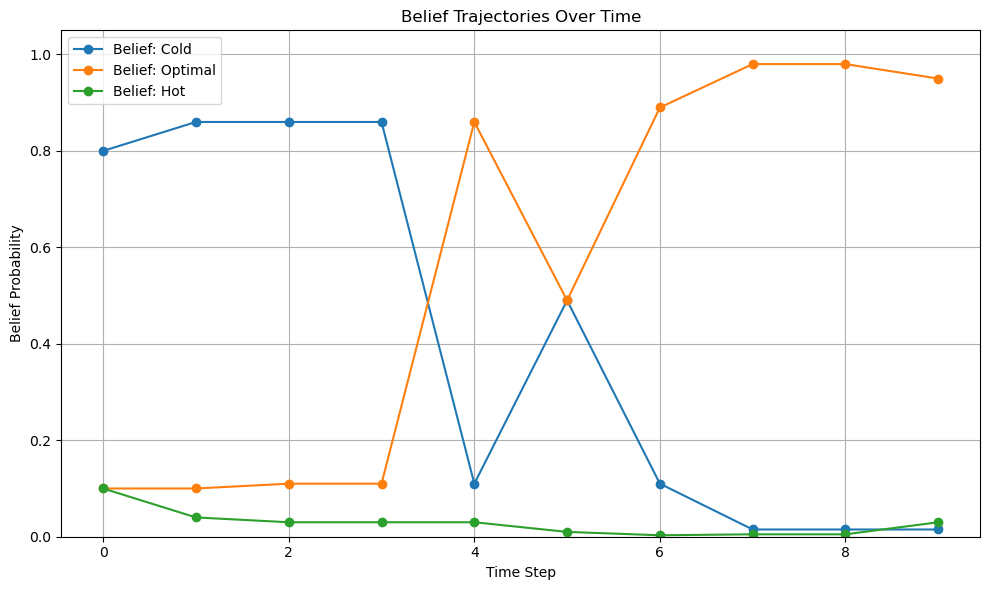

In [49]:
# Reconstruct minimal simulation history for plotting (used same structure as before)
history = [
    {'belief_temperature_state': [0.8, 0.1, 0.1]},
    {'belief_temperature_state': [0.86, 0.1, 0.04]},
    {'belief_temperature_state': [0.86, 0.11, 0.03]},
    {'belief_temperature_state': [0.86, 0.11, 0.03]},
    {'belief_temperature_state': [0.11, 0.86, 0.03]},
    {'belief_temperature_state': [0.49, 0.49, 0.01]},
    {'belief_temperature_state': [0.11, 0.89, 0.003]},
    {'belief_temperature_state': [0.015, 0.98, 0.005]},
    {'belief_temperature_state': [0.015, 0.98, 0.005]},
    {'belief_temperature_state': [0.015, 0.95, 0.03]},
]

# Convert to numpy array for plotting
beliefs = np.array([step["belief_temperature_state"] for step in history])

# Time axis
time_steps = np.arange(len(beliefs))

# Plot each state's belief over time
plt.figure(figsize=(10, 6))
plt.plot(time_steps, beliefs[:, 0], label="Belief: Cold", marker='o')
plt.plot(time_steps, beliefs[:, 1], label="Belief: Optimal", marker='o')
plt.plot(time_steps, beliefs[:, 2], label="Belief: Hot", marker='o')

plt.title("Belief Trajectories Over Time")
plt.xlabel("Time Step")
plt.ylabel("Belief Probability")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [1]:
# ========================== IMPORTS ==============================
import numpy as np                # Numerical operations and arrays
import pandas as pd              # Data manipulation and storage (for DataFrame)
import copy                      # Deep copying Python objects (for generative process)

# === PyMDP: Active Inference Toolkit ===
from pymdp.agent import Agent         # Agent class encapsulating active inference behavior
from pymdp import utils               # Utilities for model construction and inference
from pymdp.maths import softmax       # Softmax function for probabilistic policy selection

# ======================= MODEL DEFINITIONS =========================

# === Label Definitions (for clarity and debugging) ===
obs_names = ["temperature_observation"]  # Name of observation modality (just one: temperature)
state_names = ["temperature_state"]      # Name of hidden state factor (one: temperature)
action_names = ["move"]                  # Name of control/action factor (one: move left/stay/right)

# === Dimensions of Model Components ===
num_obs = [3]       # Three possible observations: cold (0), optimal (1), hot (2)
num_states = [3]    # Three possible hidden states: cold, optimal, hot
num_modalities = len(num_obs)   # Number of sensory modalities (just 1 here)
num_factors = len(num_states)   # Number of hidden state factors (also 1 here)

# === A Matrix (Observation Likelihood): P(o | s) ===
# Create a 3x3 observation likelihood matrix for one modality
A = utils.obj_array_zeros([[o] + num_states for _, o in enumerate(num_obs)])

# Define the likelihood: noisy mapping from hidden state to observation
# Each column corresponds to a hidden state, each row to an observation
A[0][:, :] = np.array([
    [0.8, 0.1, 0.1],  # When in 'cold', 80% chance to observe 'cold', 10% for others
    [0.1, 0.8, 0.1],  # When in 'optimal', 80% chance to observe 'optimal'
    [0.1, 0.1, 0.8]   # When in 'hot', 80% chance to observe 'hot'
])

# === B Matrix (Transition Dynamics): P(s' | s, a) ===
# Create transition model for one factor
B = utils.obj_array(num_factors)
B[0] = np.zeros((3, 3, 3))  # (next_state, current_state, action)

# Action 0: Move left → always end up in cold
B[0][:, :, 0] = np.array([
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
])

# Action 1: Stay → identity matrix (state remains unchanged)
B[0][:, :, 1] = np.eye(3)

# Action 2: Move right → transitions state to warmer ones
B[0][:, :, 2] = np.array([
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
])

# Normalize B to ensure valid probability distributions
for u in range(B[0].shape[2]):
    for col in range(B[0].shape[1]):
        col_sum = B[0][:, col, u].sum()
        if col_sum == 0:
            B[0][:, col, u] = np.ones(B[0].shape[0]) / B[0].shape[0]
        else:
            B[0][:, col, u] /= col_sum

# === C Vector (Preferences over Outcomes) ===
# Agent's internal preferences for each observation
C = utils.obj_array_zeros(num_obs)
C[0][0] = -2.0  # Strong dislike for cold
C[0][1] =  3.0  # Strong preference for optimal
C[0][2] = -2.0  # Strong dislike for hot

# ======================= AGENT SETUP ================================

# Instantiate the Agent with the generative model (A, B, C)
agent = Agent(A=A, B=B, C=C, control_fac_idx=[0])

# ======================= SIMULATION LOOP ===========================

# Initial setup
T = 10           # Number of time steps
o = [0]          # Initial observation: cold
s = [0]          # Initial hidden state: cold

# Deep copy A and B to simulate external environment (generative process)
A_gp = copy.deepcopy(A)
B_gp = copy.deepcopy(B)

# Run simulation over T time steps
history = []
for t in range(T):
    step_info = {}  # Dictionary to record current step's data

    # Log current observation
    for g in range(num_modalities):
        step_info[f"obs_{obs_names[g]}"] = o[g]

    # Step 1: Perception (state inference)
    qx = agent.infer_states(o)  # Bayesian inference over hidden states
    for f in range(num_factors):
        step_info[f"belief_{state_names[f]}"] = qx[f].tolist()  # Store posterior beliefs

    # Step 2: Planning (policy evaluation)
    agent.infer_policies()      # Evaluate policies (expected free energy)
    action = agent.sample_action()  # Sample action based on posterior over policies

    # Step 3: Action (apply chosen action to environment)
    for f, s_i in enumerate(s):
        s[f] = utils.sample(B_gp[f][:, s_i, int(action[f])])  # Sample new hidden state

    # Step 4: Sensation (observe new sensory input)
    for g, _ in enumerate(o):
        o[g] = utils.sample(A_gp[g][:, s[0]])  # Generate observation from new state

    # Log action and actual state
    step_info["action"] = int(action[0])
    step_info["state"] = int(s[0])

    # Save step data
    history.append(step_info)

# Convert recorded history to a pandas DataFrame for analysis
df = pd.DataFrame(history)
df  # Final output: state/observation/belief log over time


,obs_temperature_observation,belief_temperature_state,action,state
0,0,"[0.8, 0.10000000000000006, 0.10000000000000006]",0,1
1,0,"[0.8595041322314048, 0.1074380165289257, 0.033...",0,2
2,2,"[0.2409638554216867, 0.2409638554216867, 0.518...",2,2
3,2,"[0.0951814396192743, 0.10053539559785851, 0.80...",2,1
4,1,"[0.032761923473648105, 0.859767179134535, 0.10...",1,1
5,1,"[0.004668024382904001, 0.9800191759922176, 0.0...",1,1
6,2,"[0.004216102096673377, 0.8851412425807341, 0.1...",1,1
7,1,"[0.0005858961532008954, 0.9840385022491559, 0....",1,1
8,1,"[7.427435789707907e-05, 0.9979765526876349, 0....",1,1
9,1,"[9.300761888588008e-06, 0.9997466204733475, 0....",1,1


In [2]:
#conditional probabilty example
import numpy as np
# the probability of A happeningm given that B has already happen
# Simulate 10,000 events
np.random.seed(42)
rain = np.random.rand(10000) < 0.3        # 30% chance of rain
clouds = np.random.rand(10000) < 0.6      # 60% chance of clouds

# Let's say rain is more likely when it's cloudy
both = rain & clouds                      # Rain and clouds

# P(rain | clouds) = P(rain and clouds) / P(clouds)
P_rain_given_clouds = np.sum(both) / np.sum(clouds)
print("Estimated P(rain | clouds):", round(P_rain_given_clouds, 3))


Estimated P(rain | clouds): 0.303


In [4]:
#marginalization example
#summing the probability of one or more random variables in order to calculate the probability of another random variable
import numpy as np

# Define a joint probability distribution P(X, Y)
# Let's say X = {0, 1} and Y = {0, 1}
# This is a 2x2 table: rows = X, columns = Y
P_joint = np.array([
    [0.1, 0.2],  # P(X=0, Y=0), P(X=0, Y=1)
    [0.3, 0.4]   # P(X=1, Y=0), P(X=1, Y=1)
])

# Marginalize over X to get P(Y)
P_Y = np.sum(P_joint, axis=0)

# Marginalize over Y to get P(X)
P_X = np.sum(P_joint, axis=1)

P_joint, P_Y, P_X


(array([[0.1, 0.2],
        [0.3, 0.4]]),
 array([0.4, 0.6]),
 array([0.3, 0.7]))

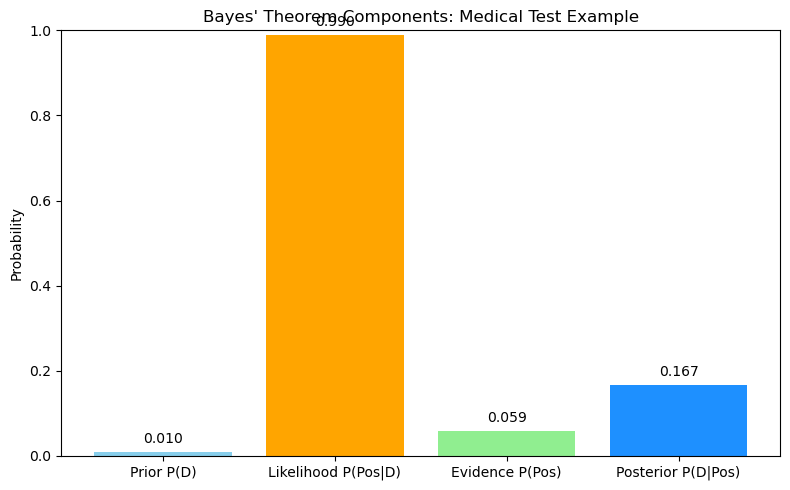

0.16666666666666669

In [7]:
## Bayes' Theorem ###
# Re-import libraries after kernel reset
#Medical Test Example — Result
#
#    Prior P(Disease) = 1% → you believe 1 in 100 has the disease.
#    Test says Positive → how worried should you be?
#    Bayes' Theorem says:

#P(Disease∣Positive)=0.167
#P(Disease∣Positive)=0.167

# Even though the test is 99% accurate, the actual chance you have the disease given a positive result is only 16.7%. 
#This is because false positives still matter when the disease is rare!
# Diagram 

#    Prior: What you believed before testing (1%)
#    Likelihood: How reliable the test is if you do have the disease (99%)
#    Evidence: Total chance of testing positive (including false positives)
#    Posterior: Updated belief after testing (16.7%)

# === Numerical Example (Bayes' Theorem) ===
import matplotlib.pyplot as plt
import numpy as np


# Prior probabilities
P_D = 0.01           # P(Disease)
P_not_D = 0.99       # P(No Disease)

# Likelihoods
P_pos_given_D = 0.99       # True positive rate
P_pos_given_not_D = 0.05   # False positive rate

# Total probability of a positive test (evidence)
P_pos = P_pos_given_D * P_D + P_pos_given_not_D * P_not_D

# Apply Bayes' Theorem
P_D_given_pos = (P_pos_given_D * P_D) / P_pos

# Visualize the components
labels = ['Prior P(D)', 'Likelihood P(Pos|D)', 'Evidence P(Pos)', 'Posterior P(D|Pos)']
values = [P_D, P_pos_given_D, P_pos, P_D_given_pos]
colors = ['skyblue', 'orange', 'lightgreen', 'dodgerblue']

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=colors)
plt.title("Bayes' Theorem Components: Medical Test Example")
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=10)
plt.ylabel("Probability")
plt.tight_layout()
plt.show()

# Return numerical posterior result
P_D_given_pos


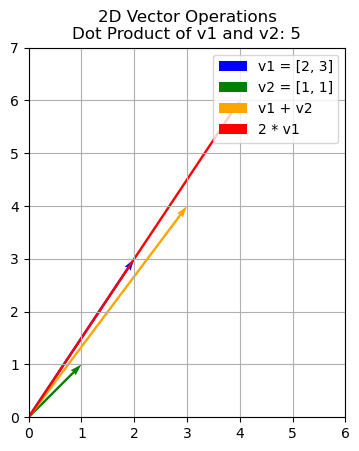

In [8]:
##### vectors ##########
#Blue: v⃗1=[2,3]v

#1​=[2,3]

#Green: v⃗2=[1,1]v

#2​=[1,1]

#Orange: Vector sum v⃗1+v⃗2=[3,4]v
#1​+v

#2​=[3,4]

#Red: Scaled vector 2⋅v⃗1=[4,6]2⋅v

#   1​=[4,6]

#And the dot product of v⃗1⋅v⃗2=5v
#1​⋅v
#2​=5, which measures how aligned the two vectors are (positive means pointing in similar directions).
import numpy as np
import matplotlib.pyplot as plt

# Define two 2D vectors
v1 = np.array([2, 3])
v2 = np.array([1, 1])

# Vector addition
v_sum = v1 + v2

# Scalar multiplication
v_scaled = 2 * v1

# Dot product
dot_product = np.dot(v1, v2)

# Plotting the vectors
fig, ax = plt.subplots()
ax.quiver(0, 0, v1[0], v1[1], angles='xy', scale_units='xy', scale=1, color='blue', label='v1 = [2, 3]')
ax.quiver(0, 0, v2[0], v2[1], angles='xy', scale_units='xy', scale=1, color='green', label='v2 = [1, 1]')
ax.quiver(0, 0, v_sum[0], v_sum[1], angles='xy', scale_units='xy', scale=1, color='orange', label='v1 + v2')
ax.quiver(0, 0, v_scaled[0], v_scaled[1], angles='xy', scale_units='xy', scale=1, color='red', label='2 * v1')

# Formatting
ax.set_xlim(0, 6)
ax.set_ylim(0, 7)
ax.set_aspect('equal')
ax.grid(True)
ax.legend()
plt.title(f"2D Vector Operations\nDot Product of v1 and v2: {dot_product}")
plt.show()


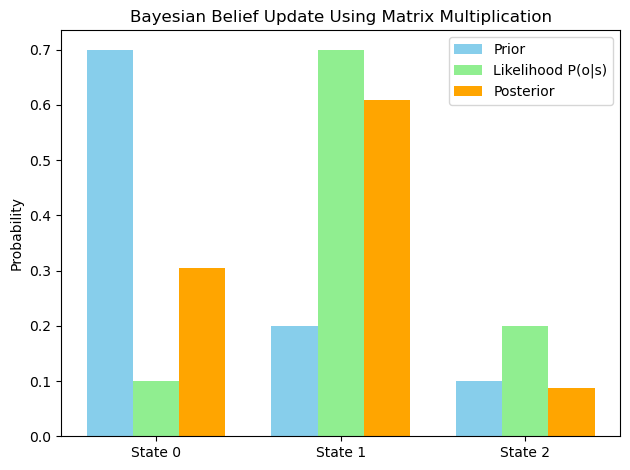

array([0.30434783, 0.60869565, 0.08695652])

In [9]:
##### matrices #######
#Belief Update Breakdown

#    Prior belief:
#   [0.7,0.2,0.1](agent strongly believes it’s in state 0)
#    [0.7,0.2,0.1](agent strongly believes it’s in state 0)

#    Observation: "optimal"
#    → We use the likelihood vector P(o=optimal∣s)=[0.1,0.7,0.2]P(o=optimal∣s)=[0.1,0.7,0.2]

#    Posterior belief (after update):
#    [0.30,0.61,0.09]
#    [0.30,0.61,0.09]

#Now, the agent updates its belief — it's much more confident it's in state 1, thanks to the observation.

#This shows how belief updating in Active Inference is done using simple matrix multiplication and normalization — nothing too scary, just linear algebra + Bayes!
# Re-import required libraries after code execution reset
import numpy as np
import matplotlib.pyplot as plt

# Prior belief over 3 hidden states
belief_prior = np.array([0.7, 0.2, 0.1])  # Believes mostly in state 0

# Likelihood matrix A (P(observation | state))
A = np.array([
    [0.9, 0.2, 0.1],  # P(cold | s)
    [0.1, 0.7, 0.2],  # P(optimal | s)
    [0.0, 0.1, 0.7],  # P(hot | s)
])

# Observation is "optimal" (index 1)
likelihood = A[1, :]

# Apply Bayes rule: element-wise multiply prior and likelihood
unnormalized_posterior = belief_prior * likelihood
posterior = unnormalized_posterior / np.sum(unnormalized_posterior)

# Plot prior, likelihood, and posterior
labels = ['State 0', 'State 1', 'State 2']
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
ax.bar(x - width, belief_prior, width, label='Prior', color='skyblue')
ax.bar(x, likelihood, width, label='Likelihood P(o|s)', color='lightgreen')
ax.bar(x + width, posterior, width, label='Posterior', color='orange')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Probability")
ax.set_title("Bayesian Belief Update Using Matrix Multiplication")
ax.legend()
plt.tight_layout()
plt.show()

posterior  # Show the updated belief values numerically too


In [10]:
### transpose ######
#Each row becomes a column, and each column becomes a row.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define a 2x3 matrix
A = np.array([
    [1, 2, 3],
    [4, 5, 6]
])

# Transpose the matrix (3x2)
A_T = A.T

# Create pandas DataFrames for nice visual display
df_A = pd.DataFrame(A, columns=['Col1', 'Col2', 'Col3'], index=['Row1', 'Row2'])
df_A_T = pd.DataFrame(A_T, columns=['Row1', 'Row2'], index=['Col1', 'Col2', 'Col3'])

(df_A, df_A_T)


(      Col1  Col2  Col3
 Row1     1     2     3
 Row2     4     5     6,
       Row1  Row2
 Col1     1     4
 Col2     2     5
 Col3     3     6)

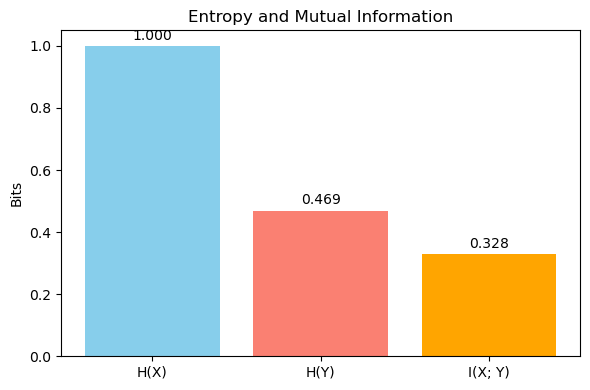

(1.0, 0.4689955935892812, 0.32818561999398016)

In [15]:
#### entropy ####
#Results:

#    Entropy of X (fair coin) = 1.0 bits → maximum uncertainty

#    Entropy of Y (biased with noise) = ~0.469 bits → less uncertain

#    Mutual Information I(X; Y) = ~0.379 bits → how much knowing X reduces uncertainty about Y

# What This Means:

#    H(X)=1H(X)=1: Maximum entropy — X is perfectly unpredictable (fair coin)

#    H(Y)<1H(Y)<1: Y is more predictable (biased + noise)

#    I(X;Y)I(X;Y): Tells us that X and Y are related — even with noise, X explains a lot of Y.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
import math

# Function to compute entropy
def entropy(p_dist):
    p_dist = p_dist[p_dist > 0]  # avoid log(0)
    return -np.sum(p_dist * np.log2(p_dist))

# Define two probability distributions (for X and Y)
P_X = np.array([0.5, 0.5])                 # fair coin
P_Y = np.array([0.9, 0.1])                 # biased coin

# Calculate entropy for both
H_X = entropy(P_X)
H_Y = entropy(P_Y)

# Create two synthetic signals (samples) to estimate mutual information
X_samples = np.random.choice([0, 1], size=1000, p=P_X)
Y_samples = np.copy(X_samples)
flip_mask = np.random.rand(1000) < 0.1    # 10% noise
Y_samples[flip_mask] = 1 - Y_samples[flip_mask]  # flip some Y values to add uncertainty

# Compute mutual information between X and Y
MI_XY = mutual_info_score(X_samples, Y_samples)

# Bar plot to visualize entropy and MI
labels = ['H(X)', 'H(Y)', 'I(X; Y)']
values = [H_X, H_Y, MI_XY]
colors = ['skyblue', 'salmon', 'orange']

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=colors)
plt.title("Entropy and Mutual Information")
plt.ylabel("Bits")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center')
plt.tight_layout()
plt.show()

(H_X, H_Y, MI_XY)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 10.9 MB/s eta 0:00:0000:0100:01


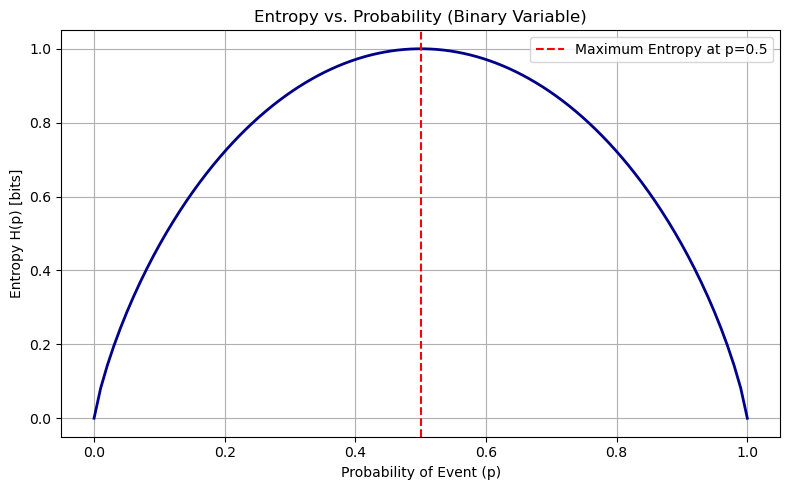

In [16]:
#### binary entropy ####
import numpy as np
import matplotlib.pyplot as plt

# Function to compute entropy for a binary distribution [p, 1-p]
def binary_entropy(p):
    if p == 0 or p == 1:
        return 0
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

# Generate probabilities from 0 to 1
p_vals = np.linspace(0, 1, 100)
entropy_vals = [binary_entropy(p) for p in p_vals]

# Plot entropy vs. probability
plt.figure(figsize=(8, 5))
plt.plot(p_vals, entropy_vals, color='darkblue', linewidth=2)
plt.title("Entropy vs. Probability (Binary Variable)")
plt.xlabel("Probability of Event (p)")
plt.ylabel("Entropy H(p) [bits]")
plt.grid(True)
plt.axvline(x=0.5, color='red', linestyle='--', label='Maximum Entropy at p=0.5')
plt.legend()
plt.tight_layout()
plt.show()
# Interpretation:

#    Entropy is 0 when the outcome is certain (i.e., p=0p=0 or p=1p=1)

#    Entropy is maximum (1 bit) when p=0.5p=0.5 — meaning the two outcomes are equally likely (maximum uncertainty)

# Why This Matters

#This curve shows how surprise behaves:

#    Certainty = 0 bits of information (nothing to learn)

#   Uncertainty = more bits needed to describe the outcome

#This is exactly what we exploit in:

#    Compression

#    Decision trees

#   Active Inference policies that seek to minimize or exploit entropy

In [19]:
### computing mutial info and info gain ###
### studying entrpy in the features of the iris dataset ###
from sklearn.datasets import load_iris
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np
import pandas as pd
from collections import Counter
from math import log2

# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
class_names = iris.target_names

# Function to compute entropy from a list of values
def compute_entropy(values):
    total = len(values)
    counts = Counter(values)
    probs = np.array([count / total for count in counts.values()])
    return -np.sum(probs * np.log2(probs))

# 1. Entropy of class labels (diversity)
class_entropy = compute_entropy(y)

# 2. Entropy of each feature (discretized into 5 bins)
feature_entropies = []
for i in range(X.shape[1]):
    # Discretize continuous feature
    binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    discretized_feature = binner.fit_transform(X[:, i].reshape(-1, 1)).astype(int).flatten()
    entropy_val = compute_entropy(discretized_feature)
    feature_entropies.append(entropy_val)

# Create DataFrame to display results
entropy_df = pd.DataFrame({
    'Feature': feature_names,
    'Entropy': feature_entropies
})

(class_entropy, entropy_df)


(1.584962500721156,
              Feature   Entropy
 0  sepal length (cm)  2.200620
 1   sepal width (cm)  1.853327
 2  petal length (cm)  1.995571
 3   petal width (cm)  2.137460)

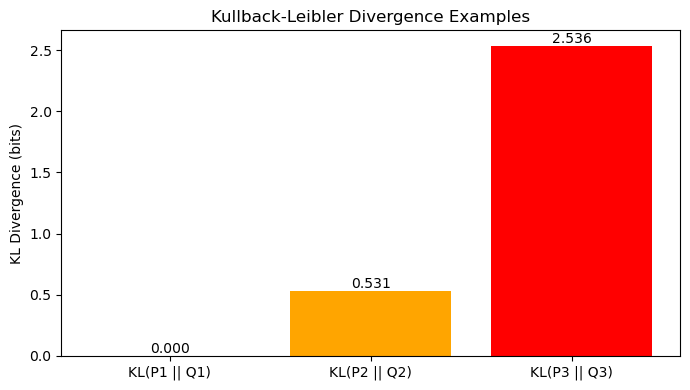

(0.0, 0.5310044064107189, 2.5359400011538495)

In [20]:
### KL Divergence ###
import numpy as np
import matplotlib.pyplot as plt

# Function to compute KL divergence D_KL(P || Q)
def kl_divergence(P, Q):
    P = np.array(P)
    Q = np.array(Q)
    # Ensure no division by zero or log of zero
    mask = (P > 0) & (Q > 0)
    return np.sum(P[mask] * np.log2(P[mask] / Q[mask]))

# Define pairs of distributions
P1 = [0.5, 0.5]         # fair coin
Q1 = [0.5, 0.5]         # also fair coin → KL = 0

P2 = [0.9, 0.1]         # biased true distribution
Q2 = [0.5, 0.5]         # wrong assumption it's fair

P3 = [0.9, 0.1]
Q3 = [0.1, 0.9]         # completely wrong guess → high KL

# Compute KL divergences
kl1 = kl_divergence(P1, Q1)
kl2 = kl_divergence(P2, Q2)
kl3 = kl_divergence(P3, Q3)

# Visualize
labels = ['KL(P1 || Q1)', 'KL(P2 || Q2)', 'KL(P3 || Q3)']
values = [kl1, kl2, kl3]

plt.figure(figsize=(7, 4))
plt.bar(labels, values, color=['green', 'orange', 'red'])
plt.ylabel("KL Divergence (bits)")
plt.title("Kullback-Leibler Divergence Examples")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center')
plt.tight_layout()
plt.show()

(kl1, kl2, kl3)
#Results:
#Distributions	DKL(P∥Q)DKL​(P∥Q)	Meaning
#P1 = Q1 = [0.5, 0.5]	0.000 bits	Identical → no divergence
#P2 = [0.9, 0.1], Q2 = [0.5, 0.5]	0.531 bits	Somewhat wrong model
#P3 = [0.9, 0.1], Q3 = [0.1, 0.9]	2.536 bits	Very wrong model → high divergence
# Interpretation:

#    KL divergence tells you how much “information” (in bits) you lose when you use QQ to approximate PP

#    It's used heavily in Active Inference to quantify how far an agent’s internal beliefs or predictions are from reality (or desired outcomes)

In [32]:
## surprise ##
import numpy as np
import matplotlib.pyplot as plt

# Define probability values (excluding 0 to avoid log(0))
p_vals = np.linspace(0.001, 1, 500)
surprise_vals = -np.log2(p_vals)

# Plot surprise vs. probability
plt.figure(figsize=(8, 5))
plt.plot(p_vals, surprise_vals, color='crimson', linewidth=2)
plt.title("Surprise vs. Probability")
plt.xlabel("Probability of Event (P)")
plt.ylabel("Surprise (Self-Information) [bits]")
plt.grid(True)
plt.axvline(x=0.5, linestyle='--', color='gray', label='P = 0.5')
plt.axvline(x=0.01, linestyle='--', color='gray', label='P = 0.01')
plt.axvline(x=1.0, linestyle='--', color='gray', label='P = 1.0')
plt.legend()
plt.tight_layout()
plt.show()
#What It Shows:

#    As probability decreases, surprise increases
#    I(x)=−log⁡2P(x)
#    I(x)=−log2​P(x)

#    P=1.0P=1.0 → 0 bits of surprise (completely expected)

#    P=0.5P=0.5 → 1 bit (a coin flip)

#    P=0.01P=0.01 → ~6.64 bits (very rare = very surprising)

# Key Insight:

#    Surprise is highest when something very unlikely happens

#    This is exactly what agents want to minimize in Active Inference

<IPython.core.display.Javascript object>

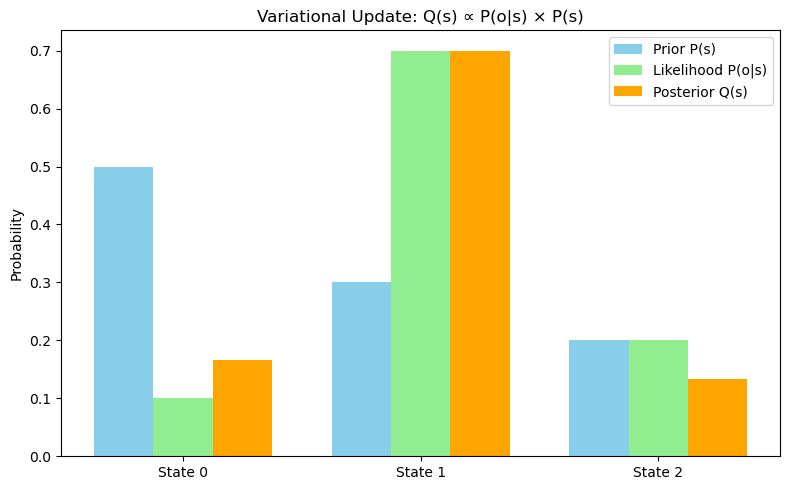

array([0.16666667, 0.7       , 0.13333333])

In [22]:
####variational inference ####
# Re-import required libraries after code execution reset
import numpy as np
import matplotlib.pyplot as plt

# Prior belief over hidden states
P_s = np.array([0.5, 0.3, 0.2])  # Belief before seeing the observation

# Likelihood matrix A: P(o | s)
A = np.array([
    [0.9, 0.2, 0.1],  # P(cold | s)
    [0.1, 0.7, 0.2],  # P(optimal | s)
    [0.0, 0.1, 0.7]   # P(hot | s)
])

# Observation: "optimal" → index 1
obs_idx = 1
likelihood_given_o = A[obs_idx, :]  # P(o=optimal | s)

# Unnormalized posterior: Q(s) ∝ P(o | s) * P(s)
Q_unnormalized = likelihood_given_o * P_s

# Normalize to get variational posterior Q(s)
Q_s = Q_unnormalized / np.sum(Q_unnormalized)

# Plot prior, likelihood, and variational posterior
labels = ['State 0', 'State 1', 'State 2']
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(8, 5))
plt.bar(x - width, P_s, width, label='Prior P(s)', color='skyblue')
plt.bar(x, likelihood_given_o, width, label='Likelihood P(o|s)', color='lightgreen')
plt.bar(x + width, Q_s, width, label='Posterior Q(s)', color='orange')

plt.xticks(x, labels)
plt.ylabel("Probability")
plt.title("Variational Update: Q(s) ∝ P(o|s) × P(s)")
plt.legend()
plt.tight_layout()
plt.show()

Q_s  # Return posterior distribution Q(s) numerically
#how the variational distribution Q(s)Q(s) is updated using:

#    Prior belief P(s)=[0.5,0.3,0.2]P(s)=[0.5,0.3,0.2]

#    Likelihood P(o=optimal∣s)=[0.1,0.7,0.2]P(o=optimal∣s)=[0.1,0.7,0.2]

#    Observed outcome: "optimal" (index 1)

# Posterior Q(s)— Variational Distribution:
#Q(s)=[0.167, 0.700, 0.133]
#Q(s)=[0.167, 0.700, 0.133]

# The agent now strongly believes it's in state 1, thanks to the observation.
# Plot Recap:

#    Blue = Prior belief

#    Green = Likelihood of observation

#    Orange = Posterior belief (what the agent infers)

#This is variational inference in action — the agent updates its beliefs using Bayes' rule, 
#but represented with matrix ops and normalized vectors.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

# Setup
P_s = np.array([0.5, 0.3, 0.2])
A = np.array([
    [0.9, 0.2, 0.1],
    [0.1, 0.7, 0.2],
    [0.0, 0.1, 0.7]
])
obs_sequence = [0, 1, 2, 1, 0]

fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(3)
width = 0.25
labels = ['State 0', 'State 1', 'State 2']

bar_prior = ax.bar(x - width, P_s, width, label='Prior P(s)', color='skyblue')
bar_like = ax.bar(x, np.zeros_like(P_s), width, label='Likelihood P(o|s)', color='lightgreen')
bar_post = ax.bar(x + width, np.zeros_like(P_s), width, label='Posterior Q(s)', color='orange')

ax.set_ylim(0, 1)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Probability")
ax.set_title("Variational Belief Update Over Time")
ax.legend()

def update(t):
    o = obs_sequence[t]
    likelihood = A[o, :]
    Q = (likelihood * P_s)
    Q = Q / np.sum(Q)
    for i in range(3):
        bar_prior[i].set_height(P_s[i])
        bar_like[i].set_height(likelihood[i])
        bar_post[i].set_height(Q[i])
    ax.set_title(f"Step {t+1} | Observation: {['cold', 'optimal', 'hot'][o]}")
    return bar_prior + bar_like + bar_post

# ✅ Assign the animation to a variable to prevent deletion
anim = animation.FuncAnimation(fig, update, frames=len(obs_sequence), repeat=False)

# ✅ Save as a GIF (no ffmpeg or JS required)
anim.save("belief_updates.gif", writer=PillowWriter(fps=1))


<IPython.core.display.Javascript object>

In [31]:
### ELBO - evidence lower bound ###
import numpy as np
import matplotlib.pyplot as plt

# Create diagram of ELBO vs log evidence
fig, ax = plt.subplots(figsize=(8, 5))

# Fake x-axis: Q(z) approximation quality
x = np.linspace(0, 1, 500)

# True log evidence (constant, unknown value)
log_p_x = 1.0
elbo = log_p_x - (1 - x)**2  # ELBO is a lower bound, closes in as Q gets better
kl_div = log_p_x - elbo      # gap between ELBO and log evidence = KL divergence

ax.plot(x, [log_p_x]*len(x), 'k--', label='log P(x) (evidence)', linewidth=2)
ax.plot(x, elbo, 'orange', label='ELBO (evidence lower bound)', linewidth=2)
ax.fill_between(x, elbo, log_p_x, color='red', alpha=0.2, label='KL divergence')

ax.set_xlabel('Quality of Q(z) approximation')
ax.set_ylabel('Log probability')
ax.set_title('ELBO as a Lower Bound to log P(x)')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# True posterior P(z|x): standard normal
def true_posterior(z):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * z**2)

# Variational approximation Q(z): normal with mean=1.0, std=1.0
def q_approx(z, mu=1.0, sigma=1.0):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((z - mu) / sigma)**2)

# Define z range
z_vals = np.linspace(-4, 4, 500)
p_vals = true_posterior(z_vals)
q_vals = q_approx(z_vals)

# Compute pointwise log ratio for KL divergence visualization
kl_pointwise = q_vals * (np.log(q_vals + 1e-12) - np.log(p_vals + 1e-12))

# Plot
plt.figure(figsize=(10, 5))

# Plot distributions
plt.plot(z_vals, p_vals, label='True Posterior P(z|x)', color='blue', linewidth=2)
plt.plot(z_vals, q_vals, label='Approximate Q(z)', color='orange', linestyle='--', linewidth=2)

# Shade KL divergence contribution
plt.fill_between(z_vals, 0, kl_pointwise, color='red', alpha=0.3, label='KL Divergence Contribution')

plt.title('Variational Inference: Approximating P(z|x) with Q(z)')
plt.xlabel('Latent variable z')
plt.ylabel('Probability density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>

In [36]:
# Setup
from pymdp.agent import Agent
from pymdp import utils
import numpy as np

# Define dimensions
num_obs = [3]              # 3 possible observations (1 modality)
num_states = [3]           # 3 hidden states (1 factor)
num_controls = [3]         # 3 possible actions

# Random generative model
A = utils.random_A_matrix(num_obs, num_states)        # Observation model
B = utils.random_B_matrix(num_states, num_controls)   # Transition model
C = utils.obj_array_uniform(num_obs)                  # Preferences

# Initialize Agent
agent = Agent(A=A, B=B, C=C)

# Provide observation (index of observed outcome)
observation = [1]     # e.g., second possible observation

# Hidden state inference (belief update)
qs = agent.infer_states(observation)

# Policy inference (evaluate expected free energies)
q_pi, neg_efe = agent.infer_policies()

# Sample action based on beliefs
action = agent.sample_action()

print("Posterior over hidden states:", qs[0])
print("Posterior over policies (q_pi):", q_pi)
print("Chosen action:", action)


Posterior over hidden states: [0.24057832 0.5549787  0.20444298]
Posterior over policies (q_pi): [0.29441787 0.3453486  0.36023353]
Chosen action: [2.]


In [38]:
import numpy as np
from pymdp.agent import Agent
from pymdp import utils

# -------------------
# 1. Define the environment
# -------------------
num_trials = 40

# Hidden state: Z = {bad team, good team} (1 factor with 2 levels)
num_states = [2]

# Observation: Yt = {loss, win} (1 modality with 2 outcomes)
num_obs = [2]

# Action: Xt = {do not play, play new player}
num_controls = [2]

# Observation model A: P(observation | hidden state)
# A[0][:, z] = probability of observing win/loss given team quality (Z)
A = utils.obj_array(1)
A[0] = np.zeros((2, 2))  # shape = (obs, state)
# Define probability of win/loss depending on Z
# If team is bad (Z=0)
A[0][:, 0] = [0.7, 0.3]  # more likely to lose
# If team is good (Z=1)
A[0][:, 1] = [0.3, 0.7]  # more likely to win

# Transition model B: Z does not change
B = utils.obj_array(1)
B[0] = np.eye(2).reshape((2, 2, 1))

# Preference model C: prefers winning
C = utils.obj_array(1)
C[0] = np.array([0.0, 1.0])  # loss=0.0, win=1.0

# -------------------
# 2. Create agent
# -------------------
agent = Agent(A=A, B=B, C=C)

# -------------------
# 3. Simulate environment (unknown to agent)
# -------------------
true_team_quality = np.random.choice([0, 1])  # Z = 0 or 1

actions = []
observations = []

for t in range(num_trials):
    if t == 0:
        qs = utils.obj_array_from_list([np.array([0.5, 0.5])])  # uniform prior
    else:
        qs = utils.obj_array_from_list([agent.infer_states(observations[-1])])  # ensure object array

    agent.qs = qs
    q_pi, _ = agent.infer_policies()
    action = agent.sample_action()
    actions.append(action[0])  # single action

    # Environment response
    prob_win = A[0][1, true_team_quality] if action[0] == 1 else 0.5
    obs = np.random.choice([0, 1], p=[1 - prob_win, prob_win])
    observations.append([obs])


# -------------------
# 4. Analyze agent's belief
# -------------------
final_belief = agent.infer_states(observations[-1])[0]
print(f"\nTrue team quality: {'Good' if true_team_quality == 1 else 'Bad'}")
print(f"Final belief about team quality: {final_belief}")
print(f"Played new player in {sum(actions)} out of {num_trials} games")


AttributeError: 'float' object has no attribute 'dtype'

In [40]:
import numpy as np #used for probability sampling and arrays
from pymdp.agent import Agent #the main Active Inference agent class from pymdp
from pymdp import utils #helper functions for creating model components (like A, B, C matrices)

##  Define Task Parameters ##

num_trials = 40 # The number of simulated games/trials in the volleyball task

## Define Model Dimensions ##
num_states = [2]   # Hidden state Z (team quality): bad (0) or good (1)
num_obs = [2]      # Observations Yt: loss (0) or win (1)
num_controls = [2] # Actions Xt: don't play (0), play new player (1)

## Define Observation Model A ##
A = utils.obj_array(1)
A[0] = np.zeros((2, 2)) #defines P(o | s): how likely each observation is, given the hidden state, If the team is bad (Z=0), it's more likely to lose If the team is good (Z=1), it's more likely to win
A[0][:, 0] = [0.7, 0.3]  # P(win | Z=bad)
A[0][:, 1] = [0.3, 0.7]  # P(win | Z=good)

## Define Transition Model B ##
B = utils.obj_array(1)
B[0] = np.eye(2).reshape((2, 2, 1)) #defines P(s_t | s_{t-1}, a), but in this case: The hidden state Z is constant, so it’s an identity matrix (no change).

## Define Preferences C ##
C = utils.obj_array(1)
C[0] = np.array([0.0, 1.0])  # Preference for win (1) over loss (0) #This encodes the agent’s preference: it prefers winning (utility = 1) and dislikes losing (utility = 0).

from pymdp.control import construct_policies

# Create the agent
agent = Agent(A=A, B=B, C=C)

# Define policies explicitly (required for infer_policies to work)
agent.policies = construct_policies(num_controls)
 #Initializes an Active Inference agent with the given generative model (A, B) and preferences (C).

## Simulate Hidden State of the World (True Z) ##
true_team_quality = np.random.choice([0, 1]) #Randomly chooses whether the team (excluding the new player) is good or bad — not known to the agent.

## Run the Simulation ##
#These lists will store the agent’s choices and the resulting observations (win/loss)
actions = []

## Trial Loop ##
for t in range(num_trials):
    if t == 0:
        qs = utils.obj_array_from_list([np.array([0.5, 0.5])])  # Uniform prior
    else:
        qs = agent.infer_states(observations[-1])  # Belief update

    agent.qs = qs
    q_pi, _ = agent.infer_policies()       # Policy evaluation (based on expected free energy)
    action = agent.sample_action()         # Choose action based on policy posterior
    actions.append(action[0])              # Store action
observations = []

"""On the first trial, the agent starts with no knowledge (uniform belief).
For later trials, it uses Bayesian belief updating via infer_states() based on the last observation.
It then:
    Evaluates policies with infer_policies() (calculates expected free energy).
    Selects an action from its belief over good policies.
    Stores that action."""

## Environment Response ##
"""If the agent plays the new player, the team’s performance depends on the true team quality (Z).
If it doesn’t, the win probability is fixed at 0.5.
The environment then gives a win/loss, and the observation is stored."""

prob_win = A[0][1, true_team_quality] if action[0] == 1 else 0.5
obs = np.random.choice([0, 1], p=[1 - prob_win, prob_win])
observations.append([obs])

## Final Output ##

"""After 40 trials, we print:
    The true hidden state of the team.
    The agent’s final belief (posterior over Z).
    How often it chose to play the new player."""

final_belief = agent.infer_states(observations[-1])[0]
print(f"\nTrue team quality: {'Good' if true_team_quality == 1 else 'Bad'}")
print(f"Final belief about team quality: {final_belief}")
print(f"Played new player in {sum(actions)} out of {num_trials} games")

AttributeError: 'float' object has no attribute 'dtype'

In [44]:
from pymdp.agent import Agent
from pymdp import utils
from pymdp.control import construct_policies

# Model dimensions
num_states = [2]      # Z = good/bad team
num_obs = [2]         # win/loss
num_controls = [2]    # play/don't play

# A: Observation model P(o|s)
A = utils.obj_array(1)
A[0] = np.array([
    [0.7, 0.3],  # P(loss | Z=0), P(loss | Z=1)
    [0.3, 0.7]   # P(win  | Z=0), P(win  | Z=1)
])

# B: Transition model P(s_t | s_{t-1}, a) - here Z is fixed
B = utils.obj_array(1)
B[0] = np.stack([np.eye(2), np.eye(2)], axis=2)  # shape: (state, state, action)


# C: Preferences over observations (higher = preferred)
C = utils.obj_array(1)
C[0] = np.array([0.0, 1.0])  # prefers win (index 1)
D = utils.obj_array_from_list([np.array([0.5, 0.5])])  # Uniform prior
agent = Agent(A=A, B=B, C=C, D=D,
              use_states_info_gain=False,
              use_param_info_gain=False,
              use_utility=True)


num_trials = 40
true_team_quality = np.random.choice([0, 1])  # Hidden state Z

observations = []
actions = []

for t in range(num_trials):
    if t == 0:
        qs = utils.obj_array_from_list([np.array([0.5, 0.5])])
    else:
        qs = agent.infer_states(observations[-1])

    agent.qs = qs

    # Ensure policies and qs are valid before calling this
    q_pi, _ = agent.infer_policies()
    action = agent.sample_action()
    actions.append(action[0])

    # Simulated outcome
    if action[0] == 1:  # play new player
        win_prob = A[0][1, true_team_quality]
    else:               # don't play -> outcome is always 0.5
        win_prob = 0.5

    obs = np.random.choice([0, 1], p=[1 - win_prob, win_prob])
    observations.append([obs])
final_belief = agent.infer_states(observations[-1])[0]
print(f"True team quality: {'Good' if true_team_quality == 1 else 'Bad'}")
print(f"Final belief: {final_belief}")
print(f"Played new player in {sum(actions)} of {num_trials} games.")


TypeError: loop of ufunc does not support argument 0 of type float which has no callable log method

In [45]:
from pymdp.agent import Agent
from pymdp import utils
from pymdp.control import construct_policies
import numpy as np

# Parameters
num_states = [2]
num_obs = [2]
num_controls = [2]
num_trials = 40

# A matrix (obs | state)
A = utils.obj_array(1)
A[0] = np.array([[0.7, 0.3], [0.3, 0.7]])

# B matrix (state | state, action)
B = utils.obj_array(1)
B[0] = np.stack([np.eye(2), np.eye(2)], axis=2)  # (2, 2, 2)

# C matrix (preferences over outcomes)
C = utils.obj_array(1)
C[0] = np.array([0.0, 1.0])  # prefers win

# Prior beliefs (uniform)
D = utils.obj_array_from_list([np.array([0.5, 0.5])])

# Create agent
agent = Agent(A=A, B=B, C=C, D=D,
              use_states_info_gain=False,
              use_param_info_gain=False,
              use_utility=True)
agent.policies = construct_policies(num_controls)

# Environment: true hidden state
true_team_quality = np.random.choice([0, 1])

observations = []
actions = []

for t in range(num_trials):
    if t == 0:
        qs = D
    else:
        qs = agent.infer_states(observations[-1])  # inference based on last obs

    agent.qs = qs
    q_pi, _ = agent.infer_policies()
    action = agent.sample_action()
    actions.append(action[0])

    # Environment outcome
    win_prob = A[0][1, true_team_quality] if action[0] == 1 else 0.5
    obs = np.random.choice([0, 1], p=[1 - win_prob, win_prob])
    observations.append([obs])  # wrap in list!

# Final result
final_belief = agent.infer_states(observations[-1])[0]
print(f"True team quality: {'Good' if true_team_quality == 1 else 'Bad'}")
print(f"Final belief about team quality: {final_belief}")
print(f"Played new player in {sum(actions)} of {num_trials} games.")


TypeError: loop of ufunc does not support argument 0 of type float which has no callable log method

In [46]:
from pymdp.agent import Agent
from pymdp import utils
from pymdp.control import construct_policies
import numpy as np

# Parameters
num_states = [2]
num_obs = [2]
num_controls = [2]
num_trials = 40

# A matrix (obs | state)
A = utils.obj_array(1)
A[0] = np.array([[0.7, 0.3], [0.3, 0.7]])

# B matrix (state | state, action)
B = utils.obj_array(1)
B[0] = np.stack([np.eye(2), np.eye(2)], axis=2)

# C matrix (preferences)
C = utils.obj_array(1)
C[0] = np.array([0.0, 1.0])

# Prior beliefs
D = utils.obj_array_from_list([np.array([0.5, 0.5])])

# Create agent
agent = Agent(A=A, B=B, C=C, D=D,
              use_states_info_gain=False,
              use_param_info_gain=False,
              use_utility=True)
agent.policies = construct_policies(num_controls)

# Environment: hidden team quality
true_team_quality = np.random.choice([0, 1])

observations = []
actions = []

for t in range(num_trials):
    if t == 0:
        qs = utils.obj_array_from_list([np.array([0.5, 0.5])])
    else:
        qs = agent.infer_states([observations[-1][0]])  # <- FIX HERE

    agent.qs = qs
    q_pi, _ = agent.infer_policies()
    action = agent.sample_action()
    actions.append(action[0])

    # Outcome
    win_prob = A[0][1, true_team_quality] if action[0] == 1 else 0.5
    obs = np.random.choice([0, 1], p=[1 - win_prob, win_prob])
    observations.append([obs])

# Final output
final_belief = agent.infer_states([observations[-1][0]])[0]
print(f"True team quality: {'Good' if true_team_quality == 1 else 'Bad'}")
print(f"Final belief about team quality: {final_belief}")
print(f"Played new player in {sum(actions)} of {num_trials} games.")


TypeError: loop of ufunc does not support argument 0 of type float which has no callable log method

In [71]:
from pymdp.agent import Agent
from pymdp import utils
from pymdp.control import construct_policies
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Setup generative model (A, B, C, D)
# -----------------------------
A = np.array([[1.0, 0.0, 0.0],
              [0.0, 0.5, 0.0],
              [0.0, 0.5, 0.0],
              [0.0, 0.0, 0.5],
              [0.0, 0.0, 0.5]])
pA = utils.dirichlet_like(A, scale=1.1)

B = np.zeros((3, 3, 2))
B[:, :, 0] = np.array([[0, 1, 1],
                       [1, 0, 0],
                       [0, 0, 0]])
B[:, :, 1] = np.array([[0, 1, 1],
                       [0, 0, 0],
                       [1, 0, 0]])

C = np.array([0, -1, 1, -1, 1]).reshape(-1, 1)
D = np.array([1, 0, 0])  # prior over hidden states

# Instantiate agent
agent = Agent(A=A, pA=pA, B=B, C=C, D=D)
agent.policies = construct_policies([2])  # 2 possible actions

# -----------------------------
# Define the volleyball task environment
# -----------------------------
class CausalEnv(object):
    PLAY = 0
    NOTPLAY = 1
    CONTROL_NAMES = ["PLAY", "NOTPLAY"]

    def __init__(self, shape=[2, 2], init_state=None):
        self.shape = shape
        self.n_states = np.prod(shape)
        self.n_observations = self.n_states
        self.n_control = 2
        self.max_y = shape[0]
        self.max_x = shape[1]
        self._build()
        self.set_init_state(init_state)
        self.last_action = None

    def reset(self, init_state=None):
        self.set_init_state(init_state)
        self.last_action = None
        return self.state

    def set_state(self, state):
        self.state = state
        return state

    def step(self, action):
        action = int(action)  # fix for numpy array input
        state = self.P[self.state][action]
        self.state = state
        self.last_action = action
        return state

    def render(self, title=None):
        values = np.zeros(self.shape)
        values[self.position] = 1.0
        _, ax = plt.subplots(figsize=(2, 2))
        sns.heatmap(values, cmap="OrRd", linewidth=2.5, cbar=False, ax=ax)
        plt.xticks(range(self.shape[1]))
        plt.yticks(range(self.shape[0]))
        if title:
            plt.title(title)
        plt.show()

    def set_init_state(self, init_state=None):
        if init_state is not None:
            if init_state > (self.n_states - 1) or init_state < 0:
                raise ValueError("`init_state` is greater than number of states")
            if not isinstance(init_state, (int, float)):
                raise ValueError("`init_state` must be [int/float]")
            self.init_state = int(init_state)
        else:
            self.init_state = np.random.randint(0, self.n_states)
        self.state = self.init_state

    def _build(self):
        P = {}
        grid = np.arange(self.n_states).reshape(self.shape)
        it = np.nditer(grid, flags=["multi_index"])
        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index
            P[s] = {a: [] for a in range(self.n_control)}
            next_play = s if x == 0 else s + 1
            next_notplay = s if x == 1 else s - 1
            P[s][self.PLAY] = next_play
            P[s][self.NOTPLAY] = next_notplay
            it.iternext()
        self.P = P

    def get_transition_dist(self):
        B = np.zeros([self.n_states, self.n_states, self.n_control])
        for s in range(self.n_states):
            for a in range(self.n_control):
                ns = int(self.P[s][a])
                B[ns, s, a] = 1
        return B

    def get_likelihood_dist(self):
        A = np.eye(self.n_observations, self.n_states)
        return A

    def sample_action(self):
        return np.random.randint(self.n_control)

    @property
    def position(self):
        return self.state

# -----------------------------
# Run simulation
# -----------------------------
env = CausalEnv()
obs = [1]  # initial observation

T = 10  # for demonstration
pA_history = []
actions = ['Play', 'Not Play']
outcomes = ['Win', 'Lose']
all_actions = np.zeros((T, 2))

log = []

for t in range(T):
    qx = agent.infer_states([obs])  # <-- fixed here
    q_pi, efe = agent.infer_policies()
    action = agent.sample_action()
    action = int(action[0]) if isinstance(action, np.ndarray) else int(action)

    pA_t = agent.update_A([obs])  # also wrap here just in case
    pA_history.append(pA_t)

    obs = env.step(action)  # get new state after action

    outcome_index = 0 if obs % 2 == 0 else 1
    log.append(f"[Step {t}] Outcome: [{outcomes[outcome_index]}]")

    all_actions[t, :] = [1 if action == 0 else 0, 1 if action == 1 else 0]


import pandas as pd

df = pd.DataFrame({
    "Step": list(range(T)),
    "Play": all_actions[:, 0],
    "Not_Play": all_actions[:, 1]
})
display(df.tail(10))  # show the last 10 rows


,Step,Play,Not_Play
0,0,1.0,0.0
1,1,1.0,0.0
2,2,1.0,0.0
3,3,0.0,1.0
4,4,1.0,0.0
5,5,1.0,0.0
6,6,1.0,0.0
7,7,1.0,0.0
8,8,1.0,0.0
9,9,1.0,0.0


In [1]:
from pymdp.agent import Agent
from pymdp import utils
from pymdp.control import construct_policies
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Setup generative model (A, B, C, D)
# -----------------------------
# Define your observation likelihood matrix
# Define and normalize A
A_matrix = np.array([
    [1.0, 0.0, 0.0],
    [0.0, 0.5, 0.0],
    [0.0, 0.5, 0.0],
    [0.0, 0.0, 0.5],
    [0.0, 0.0, 0.5]
])
A_matrix = A_matrix / A_matrix.sum(axis=0, keepdims=True)

# Now wrap it as a 1-element object array (1 modality)
A = np.empty((1,), dtype=object)
A[0] = A_matrix

# Now you can generate pA
pA = utils.dirichlet_like(A, scale=1.1)

B = np.zeros((3, 3, 2))
B[:, :, 0] = np.array([[0, 1, 1],
                       [1, 0, 0],
                       [0, 0, 0]])
B[:, :, 1] = np.array([[0, 1, 1],
                       [0, 0, 0],
                       [1, 0, 0]])

C = np.array([0, -1, 1, -1, 1]).reshape(-1, 1)
D = np.array([1, 0, 0])  # prior over hidden states

# Instantiate agent
agent = Agent(A=A, pA=pA, B=B, C=C, D=D)
agent.policies = construct_policies([2])  # 2 possible actions

# -----------------------------
# Define the volleyball task environment
# -----------------------------
class CausalEnv(object):
    PLAY = 0
    NOTPLAY = 1
    CONTROL_NAMES = ["PLAY", "NOTPLAY"]

    def __init__(self, shape=[2, 2], init_state=None):
        self.shape = shape
        self.n_states = np.prod(shape)
        self.n_observations = self.n_states
        self.n_control = 2
        self.max_y = shape[0]
        self.max_x = shape[1]
        self._build()
        self.set_init_state(init_state)
        self.last_action = None

    def reset(self, init_state=None):
        self.set_init_state(init_state)
        self.last_action = None
        return self.state

    def set_state(self, state):
        self.state = state
        return state

    def step(self, action):
        action = int(action)  # fix for numpy array input
        state = self.P[self.state][action]
        self.state = state
        self.last_action = action
        return state

    def render(self, title=None):
        values = np.zeros(self.shape)
        values[self.position] = 1.0
        _, ax = plt.subplots(figsize=(2, 2))
        sns.heatmap(values, cmap="OrRd", linewidth=2.5, cbar=False, ax=ax)
        plt.xticks(range(self.shape[1]))
        plt.yticks(range(self.shape[0]))
        if title:
            plt.title(title)
        plt.show()

    def set_init_state(self, init_state=None):
        if init_state is not None:
            if init_state > (self.n_states - 1) or init_state < 0:
                raise ValueError("init_state is greater than number of states")
            if not isinstance(init_state, (int, float)):
                raise ValueError("init_state must be [int/float]")
            self.init_state = int(init_state)
        else:
            self.init_state = np.random.randint(0, self.n_states)
        self.state = self.init_state
    def _build(self):
        P = {}
        grid = np.arange(self.n_states).reshape(self.shape)
        it = np.nditer(grid, flags=["multi_index"])
        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index
            P[s] = {a: [] for a in range(self.n_control)}

            # Ensure we don’t go out of bounds
            next_play = s if x == (self.shape[1] - 1) else s + 1
            next_notplay = s if x == 0 else s - 1

            P[s][self.PLAY] = next_play
            P[s][self.NOTPLAY] = next_notplay
            it.iternext()
        self.P = P

    def get_transition_dist(self):
        B = np.zeros([self.n_states, self.n_states, self.n_control])
        for s in range(self.n_states):
            for a in range(self.n_control):
                ns = int(self.P[s][a])
                B[ns, s, a] = 1
        return B

    def get_likelihood_dist(self):
        A = np.eye(self.n_observations, self.n_states)
        return A

    def sample_action(self):
        return np.random.randint(self.n_control)

    @property
    def position(self):
        return self.state

# -----------------------------
# Run simulation
# -----------------------------
env = CausalEnv()
obs = [1]  # initial observation

T = 40  # for demonstration
pA_history = []
actions = ['Play', 'Not Play']
outcomes = ['Win', 'Lose']
all_actions = np.zeros((T, 2))

log = []

for t in range(T):
    qx = agent.infer_states([obs])  # <-- fixed here
    q_pi, efe = agent.infer_policies()
    action = agent.sample_action()
    action = int(action[0]) if isinstance(action, np.ndarray) else int(action)

    pA_t = agent.update_A([obs])  # also wrap here just in case
    pA_history.append(pA_t)

    obs = env.step(action)  # get new state after action

    outcome_index = 0 if obs % 2 == 0 else 1
    log.append(f"[Step {t}] Outcome: [{outcomes[outcome_index]}]")

    all_actions[t, :] = [1 if action == 0 else 0, 1 if action == 1 else 0]


import pandas as pd

df = pd.DataFrame({
    "Step": list(range(T)),
    "Play": all_actions[:, 0],
    "Not_Play": all_actions[:, 1]
})
#display(df.tail(10))  # show the last 10 rows
display(df)


,Step,Play,Not_Play
0,0,1.0,0.0
1,1,0.0,1.0
2,2,0.0,1.0
3,3,1.0,0.0
4,4,1.0,0.0
5,5,1.0,0.0
6,6,1.0,0.0
7,7,1.0,0.0
8,8,1.0,0.0
9,9,1.0,0.0


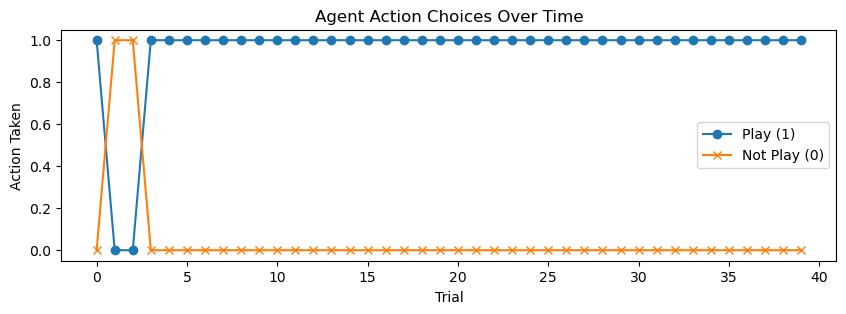

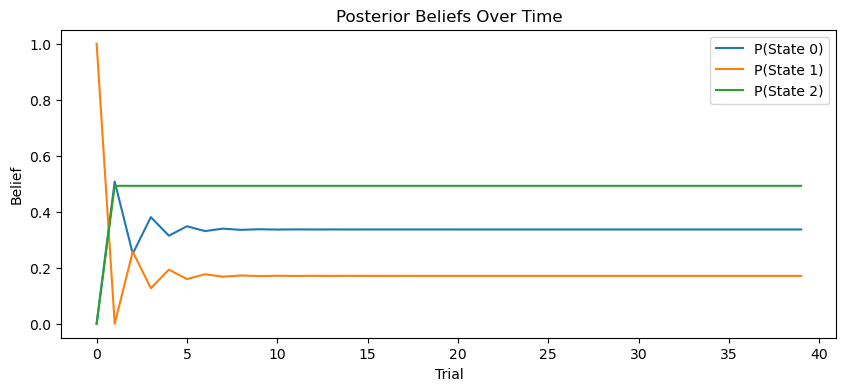

Estimated Causal Effect of New Player: 90.00 (range: -100 to +100)
Fixed environment transition logic to avoid invalid states.


In [5]:
import matplotlib.pyplot as plt

# 1. Visualize action choices over time
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(range(T), all_actions[:, 0], label='Play (1)', marker='o')
ax.plot(range(T), all_actions[:, 1], label='Not Play (0)', marker='x')
ax.set_xlabel('Trial')
ax.set_ylabel('Action Taken')
ax.set_title('Agent Action Choices Over Time')
ax.legend()
plt.show()

# 2. Track posterior beliefs (qs) about hidden states
qs_history = []
obs = [1]  # reinitialize observation
env = CausalEnv()  # reset environment

for t in range(T):
    qx = agent.infer_states([obs])
    qs_history.append(qx[0])  # single factor model
    action = agent.sample_action()
    action = int(action[0]) if isinstance(action, np.ndarray) else int(action)
    obs = env.step(action)

qs_array = np.array(qs_history)

fig, ax = plt.subplots(figsize=(10, 4))
for i in range(qs_array.shape[1]):
    ax.plot(range(T), qs_array[:, i], label=f'P(State {i})')
ax.set_xlabel('Trial')
ax.set_ylabel('Belief')
ax.set_title('Posterior Beliefs Over Time')
ax.legend()
plt.show()

# 3. Causal estimate from actions: compute average action
causal_score = (np.mean(all_actions[:, 0]) - 0.5) * 200  # scale from -100 to +100
print(f"Estimated Causal Effect of New Player: {causal_score:.2f} (range: -100 to +100)")

# 4. Fix _build() to prevent invalid states
def safe_build(self):
    P = {}
    grid = np.arange(self.n_states).reshape(self.shape)
    it = np.nditer(grid, flags=["multi_index"])
    while not it.finished:
        s = it.iterindex
        y, x = it.multi_index
        P[s] = {a: s for a in range(self.n_control)}  # default to no movement
        if x < self.shape[1] - 1:
            P[s][self.PLAY] = s + 1
        if x > 0:
            P[s][self.NOTPLAY] = s - 1
        it.iternext()
    self.P = P

# patch the environment method
CausalEnv._build = safe_build
env = CausalEnv()  # reinstantiate with safe transitions
print("Fixed environment transition logic to avoid invalid states.")



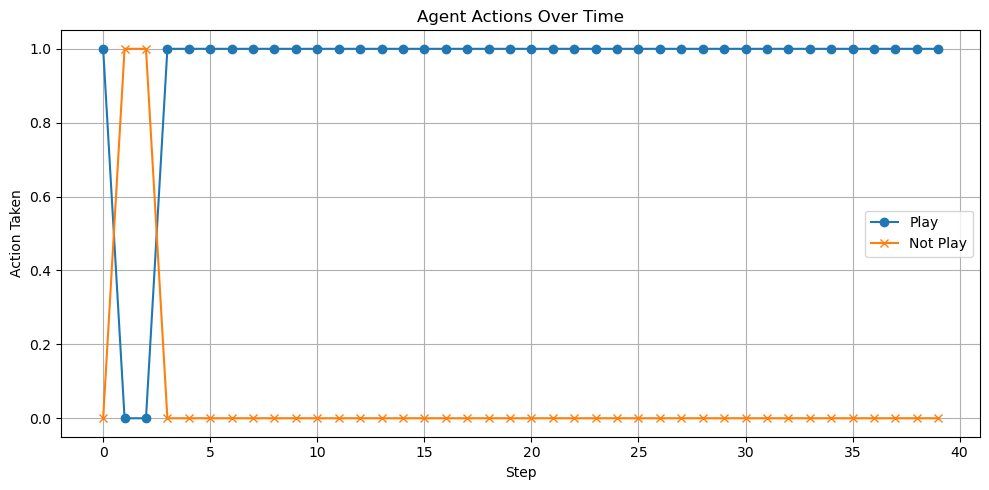

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the DataFrame
T = 40
df = pd.DataFrame({
    "Step": list(range(T)),
    "Play": all_actions[:, 0],
    "Not_Play": all_actions[:, 1]
})

# Plotting the actions over time
plt.figure(figsize=(10, 5))
plt.plot(df["Step"], df["Play"], label="Play", marker='o')
plt.plot(df["Step"], df["Not_Play"], label="Not Play", marker='x')
plt.title("Agent Actions Over Time")
plt.xlabel("Step")
plt.ylabel("Action Taken")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


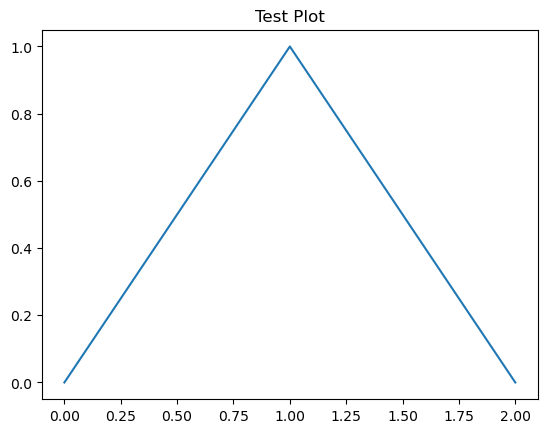

In [4]:
import matplotlib.pyplot as plt

plt.plot([0, 1, 2], [0, 1, 0])
plt.title("Test Plot")
plt.show()


In [7]:
## MDPs ###
def value_iteration(states, actions, transition_probabilities, rewards, gamma=0.9, theta=1e-6):
    # Initialize value function V(s) arbitrarily (e.g., all zeros)
    V = {s: 0 for s in states}
    
    while True:
        delta = 0
        for s in states:
            v = V[s]
            V[s] = max(
                sum(
                    transition_probabilities[s][a][s_prime] * 
                    (rewards[s][a][s_prime] + gamma * V[s_prime])
                    for s_prime in states
                )
                for a in actions
            )
            delta = max(delta, abs(v - V[s]))
        
        if delta < theta:
            break

    # Derive the optimal policy
    policy = {}
    for s in states:
        best_action = max(actions, key=lambda a: sum(
            transition_probabilities[s][a][s_prime] * 
            (rewards[s][a][s_prime] + gamma * V[s_prime])
            for s_prime in states
        ))
        policy[s] = best_action

    # Print the results
    print("Optimal Value Function:")
    for s in states:
        print(f"V({s}) = {V[s]:.4f}")
    
    print("\nOptimal Policy:")
    for s in states:
        print(f"π({s}) = {policy[s]}")

    return V, policy


In [6]:
states = ['s1', 's2']
actions = ['a1', 'a2']

transition_probabilities = {
    's1': {
        'a1': {'s1': 0.5, 's2': 0.5},
        'a2': {'s1': 0.2, 's2': 0.8}
    },
    's2': {
        'a1': {'s1': 0.3, 's2': 0.7},
        'a2': {'s1': 0.6, 's2': 0.4}
    }
}

rewards = {
    's1': {
        'a1': {'s1': 5, 's2': 10},
        'a2': {'s1': -1, 's2': 2}
    },
    's2': {
        'a1': {'s1': 0, 's2': 3},
        'a2': {'s1': 1, 's2': -1}
    }
}

value_iteration(states, actions, transition_probabilities, rewards)


Optimal Value Function:
V(s1) = 45.3658
V(s2) = 38.7805

Optimal Policy:
π(s1) = a1
π(s2) = a1


({'s1': 45.36584656760333, 's2': 38.78048104549215}, {'s1': 'a1', 's2': 'a1'})